# Workshop 5. Рекомендательная система

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже.

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [111]:
import pandas as pd

In [112]:
anime = pd.read_csv('anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [113]:
ratings = pd.read_csv('rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

<Axes: xlabel='type', ylabel='Count'>

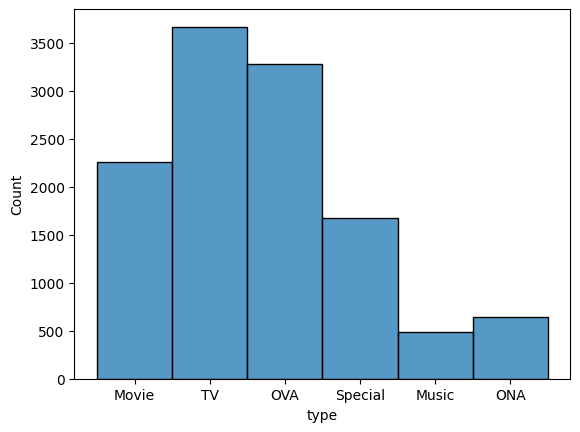

In [114]:
import seaborn as sns
sns.histplot(anime['type'])

<Axes: xlabel='episodes', ylabel='Count'>

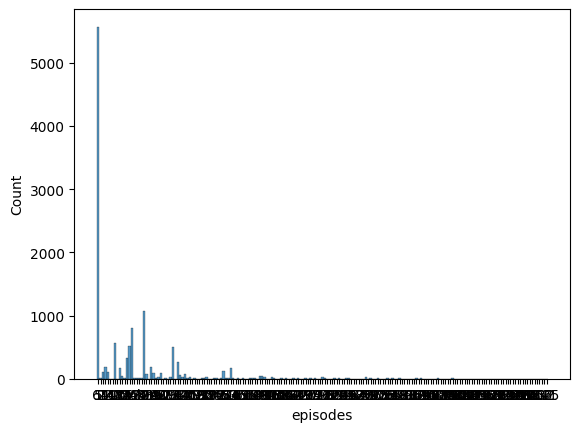

In [115]:
sns.histplot(anime['episodes'])

<Axes: xlabel='rating', ylabel='Count'>

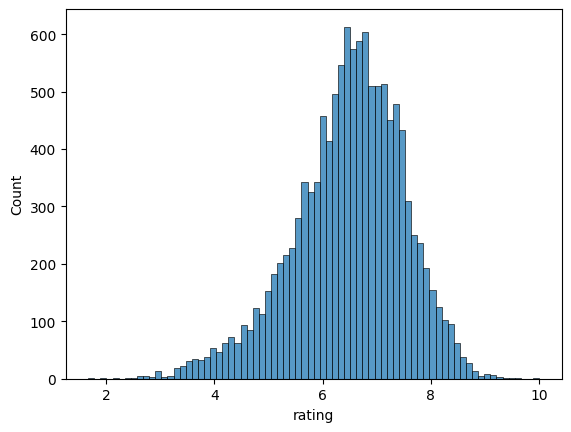

In [116]:
sns.histplot(anime['rating'])

<Axes: xlabel='members', ylabel='Count'>

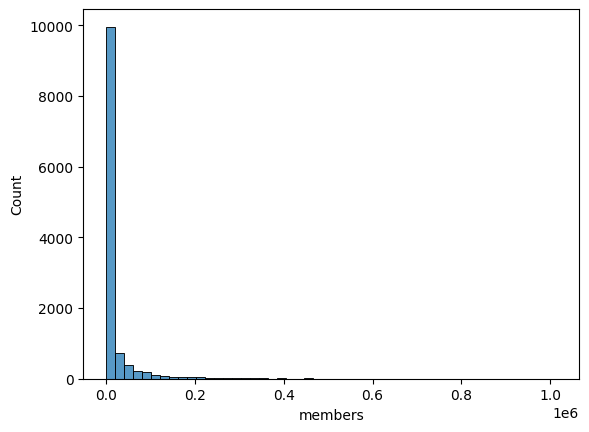

In [117]:
sns.histplot(anime['members'], bins=50)

In [118]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      12017 non-null  object 
 1   genre     12017 non-null  object 
 2   type      12017 non-null  object 
 3   episodes  12017 non-null  object 
 4   rating    12017 non-null  float64
 5   members   12017 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 657.2+ KB


In [119]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## Жанры

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

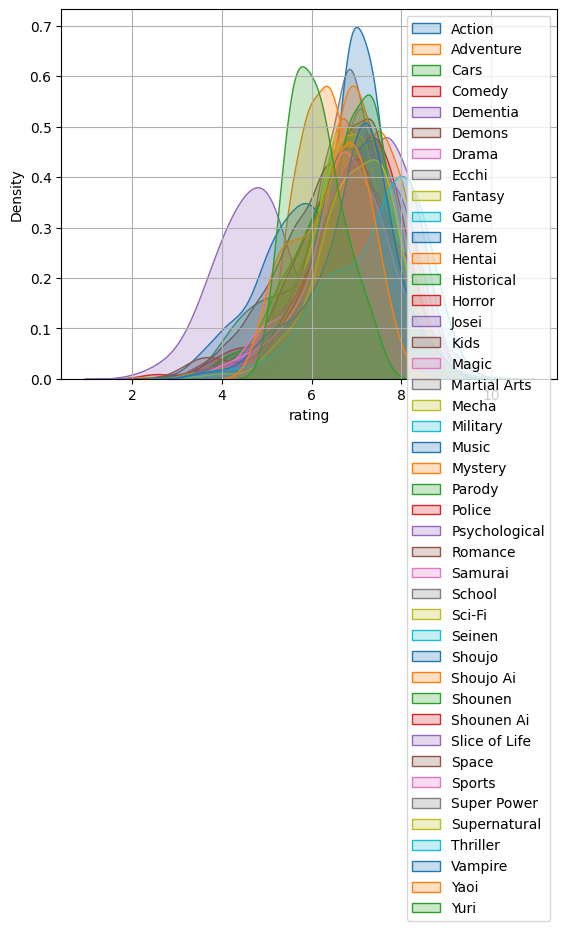

In [106]:
import matplotlib.pyplot as plt

genres = anime['genre'].str.get_dummies(sep=', ')
animePlusGenres = pd.concat([anime, genres], axis=1)
melt = pd.melt(animePlusGenres, id_vars=['rating'], value_vars=genres.columns)
melt = melt[melt['value'] == 1]

for genre in melt['variable'].unique():
    sns.kdeplot(melt[melt['variable'] == genre], x='rating', label=genre, fill=True)

plt.legend()
plt.grid()
plt.show()

## Рейтинг

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

<Axes: xlabel='rating', ylabel='count'>

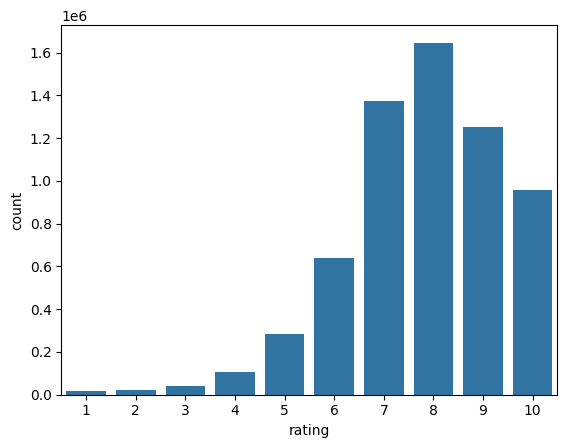

In [107]:
sns.countplot(ratings[ratings['rating'] != -1], x = 'rating')

## Фильтрация данных

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [108]:
anime_watches = ratings.groupby('anime_id').size().rename('anime_watches')
user_ratings = ratings.groupby('user_id').size().rename('user_ratings')
anime_ratings = ratings.merge(anime, on='anime_id').merge(anime_watches, on='anime_id').merge(user_ratings, on='user_id')
anime_ratings['rating'] = anime_ratings.groupby('anime_id')['rating_x'].transform(lambda x: x.replace(-1, x[x != -1].mean()))
anime_ratings = anime_ratings.drop(anime_ratings[(anime_ratings['anime_watches'] < anime_watches.median()) & (anime_ratings['user_ratings'] < user_ratings.median())].index)
anime_ratings

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,anime_watches,user_ratings,rating
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,25925,153,7.893888
1,1,24,-1,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553,7153,153,8.239298
2,1,79,-1,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772,7112,153,7.566598
3,1,226,-1,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511,27506,153,8.064434
4,1,241,-1,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395,4180,153,6.932244
...,...,...,...,...,...,...,...,...,...,...,...,...
7813606,73515,16512,7,Devil Survivor 2 The Animation,"Action, Demons, Supernatural",TV,13,7.06,101266,3504,196,7.000000
7813607,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi",Movie,1,7.64,31747,1154,196,9.000000
7813608,73515,22145,10,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",TV,10,8.37,122895,3544,196,10.000000
7813609,73516,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi",TV,23,8.03,265005,7736,2,9.000000


## Матрица user-item

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [109]:
animeRatingMatrixPivot = anime_ratings.pivot_table(index='user_id', columns='name', values='rating')
animeRatingMatrixPivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73502 entries, 1 to 73516
Columns: 9890 entries, &quot;0&quot; to ◯
dtypes: float64(9890)
memory usage: 5.4 GB


## Понижение размерности

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [110]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
animeRatingMatrix = imputer.fit_transform(animeRatingMatrixPivot)
pca = PCA(n_components=4)
animeRatingMatrix = pca.fit_transform(animeRatingMatrix)
animeRatingMatrix.shape

(73502, 4)

## Обучение kNN

Обучим kNN, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kNN
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

<Axes: xlabel='cluster'>

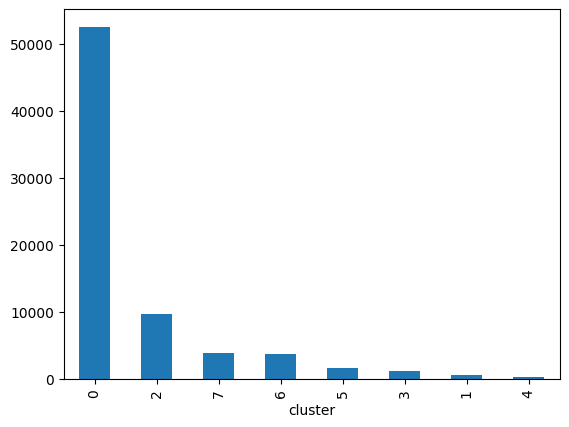

In [131]:
from sklearn.cluster import KMeans
kmeans = KMeans()
kmeans.fit(animeRatingMatrix)
animeRatingMatrixCopy = pd.DataFrame(animeRatingMatrix, index=animeRatingMatrixPivot.index)
animeRatingMatrixCopy['cluster'] = kmeans.predict(animeRatingMatrix)
animeRatingMatrixCopy['cluster'].value_counts().plot(kind='bar')

## Top 15 аниме

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере.
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга.
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [132]:
animeInClusters = anime_ratings.merge(animeRatingMatrixCopy['cluster'], left_on='user_id', right_index=True)
animeInClustersMean = animeInClusters.groupby(['cluster', 'name'])['rating'].mean().reset_index()

animeInClustersMean = animeInClustersMean.sort_values(['cluster', 'rating'], ascending=[True, False])
top15 = animeInClustersMean.groupby('cluster').head(15)
for cluster in top15['cluster'].unique():
    print(f'Кластер {cluster}\n')
    print(top15[top15['cluster'] == cluster][['name', 'rating']])
    print()

Кластер 0

                                                   name  rating
229                                       Ajisai no Uta    10.0
574                    Asari-chan: Ai no Marchen Shoujo    10.0
1336                                 Choegang Top Plate    10.0
1338         Chogattai Majutsu Robot Ginguiser Specials    10.0
1758                                            Dededen    10.0
3039                          Gozonji! Gekkou Kamen-kun    10.0
3236                                       Hamster Club    10.0
3415                Hello Kitty no Circus ga Yatte Kita    10.0
3426                      Hello Kitty no Mahou no Ringo    10.0
3442                     Hello Kitty no Tomatta Big Ben    10.0
3443                Hello Kitty no Yappari Mama ga Suki    10.0
4422           Kamiusagi Rope x Panasonic Collaboration    10.0
4426         Kanagatari. Kanabakari.: Kanadian Families    10.0
4550  Kawasaki Frontale x Tentai Senshi Sunred 2nd S...    10.0
4614    Kero Kero Keroppi no 

## Top 5 жанров

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???

In [133]:
genres1 = genres.mul(anime['rating'], axis='index')
animeInClusters1 = animeInClusters.merge(genres1, left_on='anime_id', right_index=True)
clusters = animeInClusters1.groupby(['cluster']).mean(numeric_only = True)[genres.columns]
for i in clusters.index:
  print(f'claser {i} top 5 genres:\n', '\n'.join(clusters.iloc[i].sort_values()[-5:].index))
  print()

claser 0 top 5 genres:
 Fantasy
Drama
Romance
Action
Comedy

claser 1 top 5 genres:
 Supernatural
School
Romance
Action
Comedy

claser 2 top 5 genres:
 Supernatural
Drama
Romance
Action
Comedy

claser 3 top 5 genres:
 Fantasy
Romance
Drama
Action
Comedy

claser 4 top 5 genres:
 School
Drama
Romance
Action
Comedy

claser 5 top 5 genres:
 Supernatural
School
Romance
Action
Comedy

claser 6 top 5 genres:
 Supernatural
School
Romance
Action
Comedy

claser 7 top 5 genres:
 Fantasy
Drama
Romance
Action
Comedy

